# Prepare TCGA metadata

In [1]:
library(TCGAbiolinks)
library(dplyr)
library(DT)
library(ggplot2)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# List of valid cancers
cancers <- read.table("cancers_valid.tsv") %>%
           rename("cancer"="V1") %>%
           mutate(project=paste("TCGA-",cancer,sep=""))

In [3]:
biolfile<-"../input/metadata/TCGAbiolinks.GDC_tables.tsv" # Table from BioLinks
apifile<-"../input/metadata/API_out.tsv" # Api out file
metafile<-"../input/metadata/full.ESTIMATE.API.tsv" # Output file with metadata
purityDir<-"../output/ESTIMATE/" # Directory with ESTIMATE outputs per cancer type
outDir<-"../output/processed_metadata/" # Directory to store metadata tables per cancer type

## TCGAbiolink queries

In [ ]:
bio.query <- GDCquery(project = cancers$project, 
                      data.category = "Biospecimen", 
                      file.type = "xml")
GDCdownload(bio.query)

In [ ]:
clin.query <- GDCquery(project = cancers$project, 
                       data.category = "Clinical", 
                       file.type = "xml")
GDCdownload(clin.query)

In [ ]:
# Patient clinical metatdata
patient.cols <- lapply(cancers$project,function(proj){
                    clin.proj<-GDCquery_clinic(project = proj, 
                                              type = "clinical")
                    GDCdownload(clin.proj)
                    clin.proj <- clin.proj %>% 
                                 distinct(submitter_id,age_at_diagnosis,age_at_index,race,gender,ethnicity,vital_status,tumor_grade) %>%
                                 mutate(project = proj)
                    return(clin.proj)
                }) %>% do.call(rbind,.)

In [ ]:
# Sample info
sample <- GDCprepare_clinic(bio.query, clinical.info = "sample")
sample.cols <- sample  %>% 
                distinct(bcr_patient_barcode,project,sample_type_id,sample_type)


# Stage info
stage <- GDCprepare_clinic(clin.query, clinical.info = "stage_event")
stage.cols <- stage %>%
                distinct(bcr_patient_barcode,project,pathologic_stage) 
stage_num <- c("Stage I"=1,"Stage II"=2,"Stage III"=3,"Stage IV"=4)
stage.cols$stage<-stage_num[as.character(stage.cols$pathologic_stage)]

In [ ]:
sample.cols<-sample.cols%>%rename("submitter_id"="bcr_patient_barcode")
stage.cols<-stage.cols%>%rename("submitter_id"="bcr_patient_barcode")

In [ ]:
# Merge tables and store complete file 
meta<-full_join(patient.cols,sample.cols) %>%
      full_join(.,stage.cols) %>% 
      distinct()

In [ ]:
write.table(meta,file=biolfile,sep="\t",row.names = F,col.names = T,quote = F)

## Local tables

In [4]:
# TCGA biolinks 
meta<-data.table::fread(file=biolfile,data.table=F)%>% 
      rename("patient_id"="submitter_id") 
normal_ids<-c(10,11,12,14)
meta <- meta %>%
        mutate(condition = ifelse(sample_type_id %in% normal_ids,"normal","tumor"))
head(meta)

,patient_id,age_at_diagnosis,tumor_grade,race,gender,ethnicity,vital_status,age_at_index,project,sample_type_id,sample_type,pathologic_stage,stage,condition
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<chr>
1,TCGA-OR-A5L3,24763,not reported,white,female,not hispanic or latino,Alive,67,TCGA-ACC,1,Primary Tumor,Stage I,1,tumor
2,TCGA-OR-A5L3,24763,not reported,white,female,not hispanic or latino,Alive,67,TCGA-ACC,10,Blood Derived Normal,Stage I,1,normal
3,TCGA-OR-A5JT,23794,not reported,white,female,not reported,Alive,65,TCGA-ACC,1,Primary Tumor,Stage II,2,tumor
4,TCGA-OR-A5JT,23794,not reported,white,female,not reported,Alive,65,TCGA-ACC,10,Blood Derived Normal,Stage II,2,normal
5,TCGA-OR-A5KW,20328,not reported,white,female,not hispanic or latino,Alive,55,TCGA-ACC,1,Primary Tumor,Stage III,3,tumor
6,TCGA-OR-A5KW,20328,not reported,white,female,not hispanic or latino,Alive,55,TCGA-ACC,10,Blood Derived Normal,Stage III,3,normal


In [5]:
# API info
api<-data.table::fread(apifile,data.table=F) %>%
     distinct(file_id,cases.0.samples.0.submitter_id,cases.0.project.project_id) %>%
     rename("project"="cases.0.project.project_id",
            "submitter_id"="cases.0.samples.0.submitter_id") %>%
     mutate(condition=ifelse(grepl("\\-11[A-Z]+$",submitter_id),"normal","tumor"))
api$patient_id <- strsplit(api$submitter_id,"-") %>%
                    lapply(.,function(s){paste(s[1],s[2],s[3],sep="-")}) %>%
                    unlist()
head(api)

,file_id,submitter_id,project,condition,patient_id
,<chr>,<chr>,<chr>,<chr>,<chr>
1,34320460-51a0-4a7f-adb2-6f0c1ecfc4f9,TCGA-WB-A80M-01A,TCGA-PCPG,tumor,TCGA-WB-A80M
2,21b23152-ccbd-44ad-afc3-a8b3f0b2fda2,TCGA-WB-A81T-01A,TCGA-PCPG,tumor,TCGA-WB-A81T
3,3ba4b56b-0520-46ad-b8b2-086f9e61ce6e,TCGA-QR-A6GX-01A,TCGA-PCPG,tumor,TCGA-QR-A6GX
4,1074c10f-17f7-473c-a243-8e7ba538bcfe,TCGA-WB-A820-01A,TCGA-PCPG,tumor,TCGA-WB-A820
5,f1597cdd-6556-4c30-9508-3a82fdf91e2a,TCGA-WB-A81P-01A,TCGA-PCPG,tumor,TCGA-WB-A81P
6,69a52a8a-eb63-4ff3-97d0-357d86ce7f1c,TCGA-QT-A5XL-01A,TCGA-PCPG,tumor,TCGA-QT-A5XL


In [6]:
# ESTIMATE outputs
purity<-lapply(cancers$cancer,function(cancer){
    est<-data.table::fread(paste(purityDir,cancer,"_purity_illumina.tsv",sep=""),data.table=F,drop = 2)[c(-1,-2),] %>% t()
    colnames(est)<-est[1,]
    est<-est[-1,] %>%
         as.data.frame() %>%
         rename("submitter_id"="NAME")%>%
         mutate(submitter_id=gsub("\\.","-",submitter_id),
                project = paste0("TCGA-",cancer)) %>%
         mutate(across(StromalScore:ESTIMATEScore,as.numeric),
                purity=cos(4.97499329410793+5.34321675550045e-05*ESTIMATEScore))
    return(est)
    }) %>% 
    do.call(rbind,.) 
head(purity)

,submitter_id,StromalScore,ImmuneScore,ESTIMATEScore,project,purity
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
V3,TCGA-KN-8428-01A,17986.52,18897.47,36883.99,TCGA-KICH,0.7883957
V4,TCGA-KN-8426-11A,20586.56,19706.09,40292.65,TCGA-KICH,0.6639320
V5,TCGA-KL-8329-11A,20507.39,20390.65,40898.04,TCGA-KICH,0.6393998
V6,TCGA-KL-8335-01A,18492.32,18310.17,36802.49,TCGA-KICH,0.7910671
V7,TCGA-KM-8476-01A,17295.80,18790.44,36086.24,TCGA-KICH,0.8138936
V8,TCGA-KN-8423-01A,18525.84,19818.93,38344.78,TCGA-KICH,0.7380284


## Merge all sources

In [7]:
api.purity<-left_join(api,purity) %>%
              mutate(purity=ifelse(condition=="normal",1,purity),
                     impurity=1-purity)
dim(api.purity)

Joining, by = c("submitter_id", "project")


[1] 11096    10

In [8]:
tcga<-inner_join(meta,api.purity) %>%
      group_by(submitter_id) %>%
      mutate(sample_type_list=paste(sample_type,collapse=";")) %>%
      select(-sample_type,-sample_type_id) %>%
      distinct() %>%
      as.data.frame() %>%
      left_join(.,cancers) %>%
      filter(!is.na(cancer))
rownames(tcga)<-tcga$file_id

Joining, by = c("patient_id", "project", "condition")
Joining, by = "project"


### Homogenize stage info 

In [9]:
tcga <- tcga %>% 
         mutate(stage = case_when(grepl("stage i$",pathologic_stage,ignore.case = TRUE) ~ 1,
                                  grepl("stage i[ABC|abc]*$",pathologic_stage,ignore.case = TRUE) ~ 1,
                                  grepl("stage_i[ABC|abc]*$",pathologic_stage,ignore.case = TRUE) ~ 1,

                                  grepl("stage ii$",pathologic_stage,ignore.case = TRUE) ~ 2,
                                  grepl("stage ii[ABC|abc]*$",pathologic_stage,ignore.case = TRUE) ~ 2,
                                  grepl("stage_ii[ABC|abc]*",pathologic_stage,ignore.case = TRUE) ~ 2,
                                  
                                  grepl("stage iii$",pathologic_stage,ignore.case = TRUE) ~ 3,
                                  grepl("stage iii[ABC|abc]*$",pathologic_stage,ignore.case = TRUE) ~ 3,
                                  grepl("stage_iii[ABC|abc]*",pathologic_stage,ignore.case = TRUE) ~ 3,
                                  
                                  grepl("stage iv$",pathologic_stage,ignore.case = TRUE) ~ 4,
                                  grepl("stage iv[ABC|abc]*$",pathologic_stage,ignore.case = TRUE) ~ 4,
                                  grepl("stage_iv[ABC|abc]*",pathologic_stage,ignore.case = TRUE) ~ 4,
                                  TRUE ~ 0
         
                                 ))

### Write tables

In [10]:
# Whole dataset
write.table(tcga,file=metafile,sep="\t",row.names = T,col.names = T,quote = F)

In [11]:
# Per cancer type
for(proj in cancers$project){
    print(proj)
    tcga.out <- tcga %>% filter(project==proj)
    outfile <- paste(outDir,unique(tcga.out$cancer),".csv",sep="")
    write.csv(tcga.out,file=outfile,quote=T,row.names=T)
}

[1] "TCGA-KICH"
[1] "TCGA-ACC"
[1] "TCGA-BRCA"
[1] "TCGA-BLCA"
[1] "TCGA-CESC"
[1] "TCGA-CHOL"
[1] "TCGA-COAD"
[1] "TCGA-DLBC"
[1] "TCGA-ESCA"
[1] "TCGA-GBM"
[1] "TCGA-HNSC"
[1] "TCGA-KIRC"
[1] "TCGA-KIRP"
[1] "TCGA-LAML"
[1] "TCGA-LGG"
[1] "TCGA-LIHC"
[1] "TCGA-LUAD"
[1] "TCGA-LUSC"
[1] "TCGA-MESO"
[1] "TCGA-OV"
[1] "TCGA-PAAD"
[1] "TCGA-PCPG"
[1] "TCGA-PRAD"
[1] "TCGA-READ"
[1] "TCGA-SARC"
[1] "TCGA-SKCM"
[1] "TCGA-STAD"
[1] "TCGA-TGCT"
[1] "TCGA-THCA"
[1] "TCGA-UCEC"
[1] "TCGA-UVM"


# Sanity checks

Warning message:
“Removed 651 rows containing non-finite values (`stat_boxplot()`).”


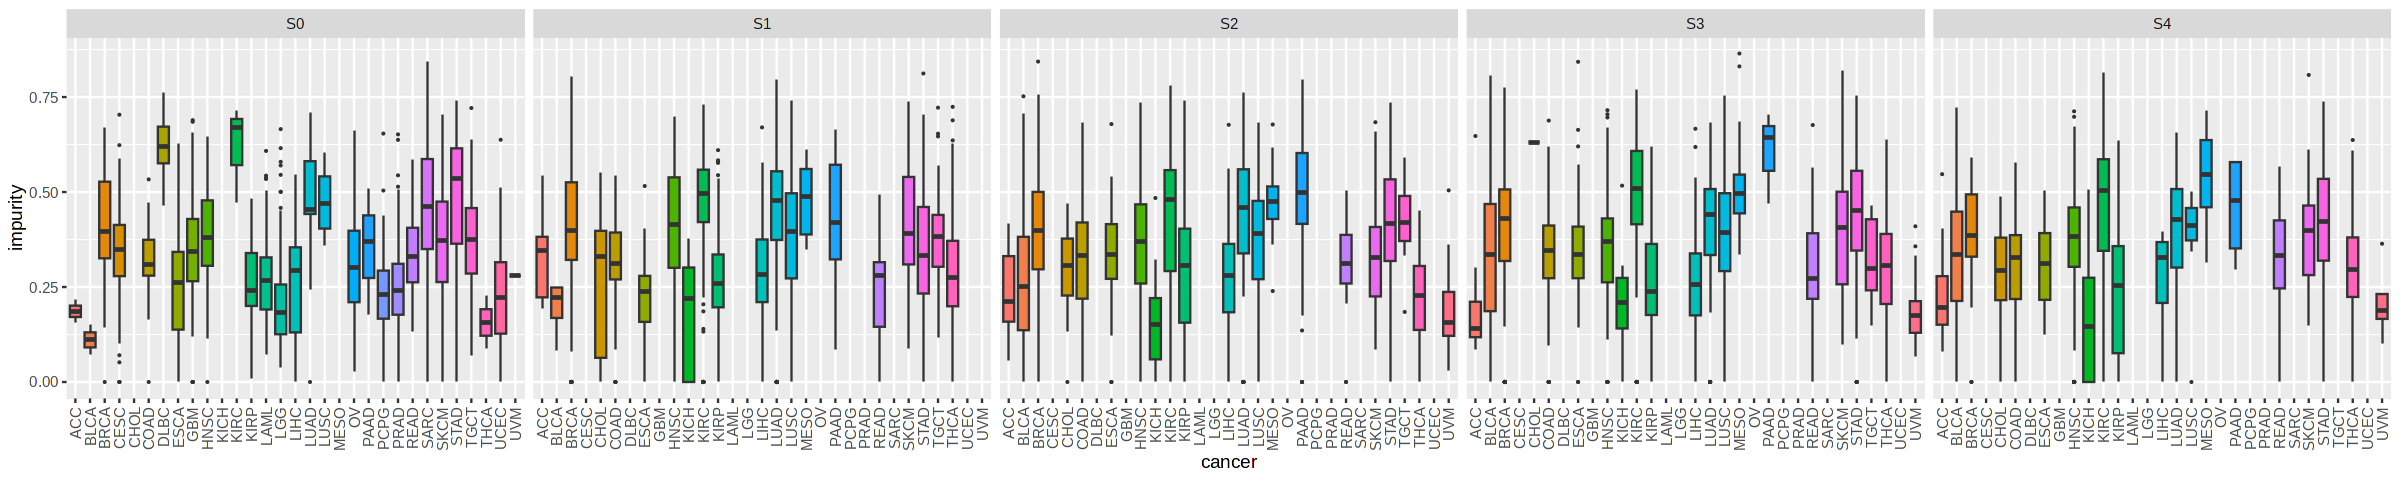

In [13]:
options(repr.plot.width=20,repr.plot.height=4)
g<-tcga %>%
 mutate(stage_group=factor(paste0("S",stage),levels=paste0("S",0:4)))%>%
 ggplot(.,aes(x=cancer,y=impurity,fill=cancer))+
    geom_boxplot(outlier.size = 0.1)+
    facet_wrap(~stage_group,ncol=5)+
    theme(legend.position="none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
g

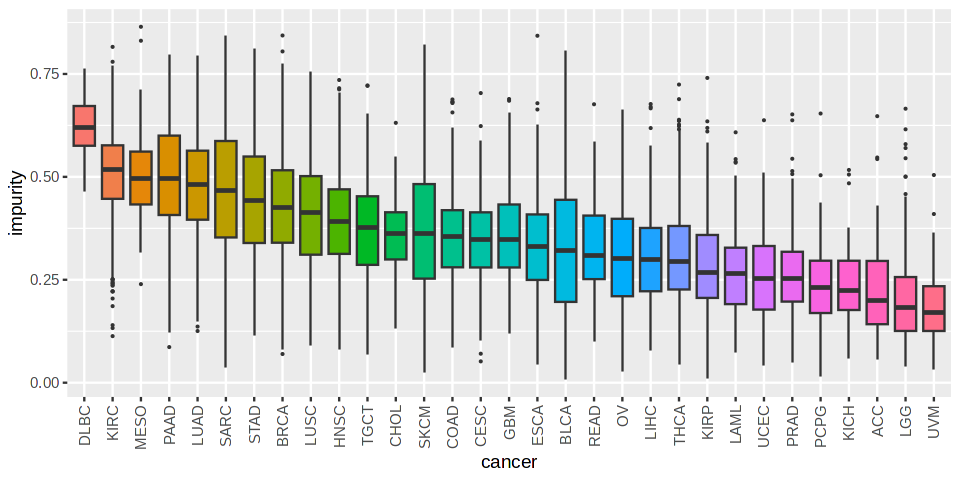

In [14]:
options(repr.plot.width=8,repr.plot.height=4)
c.ord<-tcga %>% 
    filter(condition=="tumor") %>%
    group_by(cancer) %>%
    summarize(med_imp=median(impurity,na.rm=T)) %>%
    arrange(desc(med_imp))%>%
    na.omit()
g<-tcga %>%
    filter(condition=="tumor" & !is.na(impurity))%>%
    mutate(cancer=factor(cancer,levels=c.ord$cancer)) %>%
     mutate(stage_group=factor(paste0("S",stage),levels=paste0("S",0:4)))%>%
     ggplot(.,aes(x=cancer,y=impurity,fill=cancer))+
        geom_boxplot(outlier.size = 0.1)+
        theme(legend.position="none",
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
g

Warning message:
“Removed 651 rows containing non-finite values (`stat_boxplot()`).”


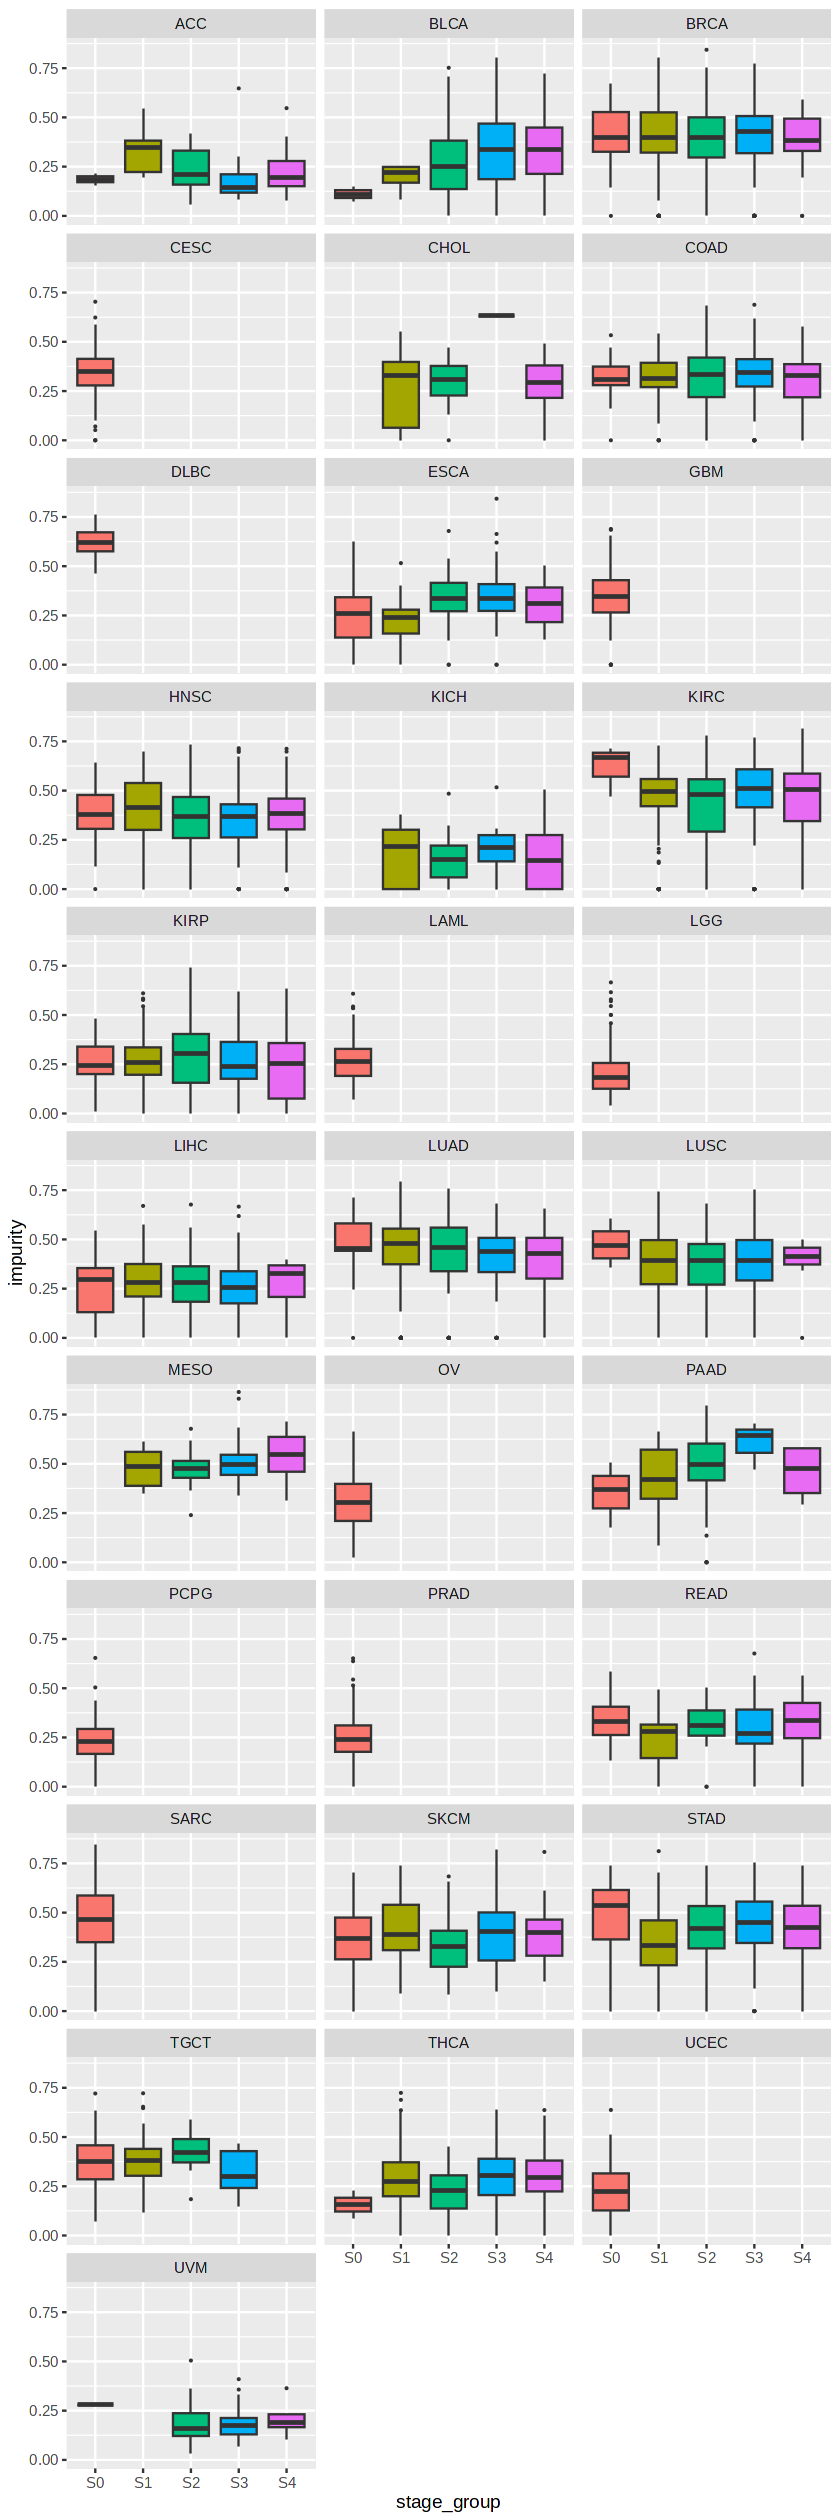

In [15]:
options(repr.plot.width=7,repr.plot.height=21)
g<-tcga %>%
     mutate(stage_group=factor(paste0("S",stage),levels=paste0("S",0:4)))%>%
     ggplot(.,aes(x=stage_group,y=impurity,fill=stage_group))+
        geom_boxplot(outlier.size = 0.1)+
        facet_wrap(~cancer,ncol=3)+
        theme(legend.position="none")
g

In [16]:
tcga %>% 
 group_by(cancer) %>%
 summarize(n_samples=length(purity),
           n_tumor=sum(condition=="tumor"),
           n_normal=sum(condition=="normal"),
           n_na_purity=sum(is.na(purity)),
           remaining = n_samples-n_na_purity) %>%
 arrange(remaining)

cancer,n_samples,n_tumor,n_normal,n_na_purity,remaining
<chr>,<int>,<int>,<int>,<int>,<int>
CHOL,45,36,9,0,45
DLBC,48,48,0,0,48
ACC,79,79,0,0,79
UVM,80,80,0,0,80
MESO,86,86,0,0,86
KICH,89,65,24,0,89
READ,177,167,10,72,105
LAML,151,151,0,0,151
TGCT,156,156,0,0,156


In [17]:
tcga %>% 
 group_by(cancer) %>%
 summarize(n_samples=length(purity),
           n_tumor=sum(condition=="tumor"),
           n_normal=sum(condition=="normal"),
           n_S0=sum(stage==0),
           n_S1=sum(stage==1),
           n_S2=sum(stage==2),
           n_S3=sum(stage==3),
           n_S4=sum(stage==4),
           n_na_purity=sum(is.na(purity)),
           remaining = n_samples-n_na_purity,
           n_v_stages=sum(n_S0!=0,n_S1!=0,n_S2!=0,n_S3!=0,n_S4!=0)) %>%
 arrange(desc(n_v_stages))

cancer,n_samples,n_tumor,n_normal,n_S0,n_S1,n_S2,n_S3,n_S4,n_na_purity,remaining,n_v_stages
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ACC,79,79,0,2,9,37,16,15,0,79,5
BLCA,433,414,19,2,4,134,149,144,0,433,5
BRCA,1222,1109,113,25,202,697,276,22,0,1222,5
COAD,521,480,41,14,85,209,140,73,186,335,5
ESCA,173,162,11,22,21,71,51,8,1,172,5
HNSC,546,502,44,69,27,86,86,278,0,546,5
KIRC,611,539,72,3,297,70,139,102,0,611,5
KIRP,321,289,32,29,187,23,63,19,0,321,5
LIHC,424,374,50,32,191,98,97,6,0,424,5
